nfft = 990
nperseg = 990


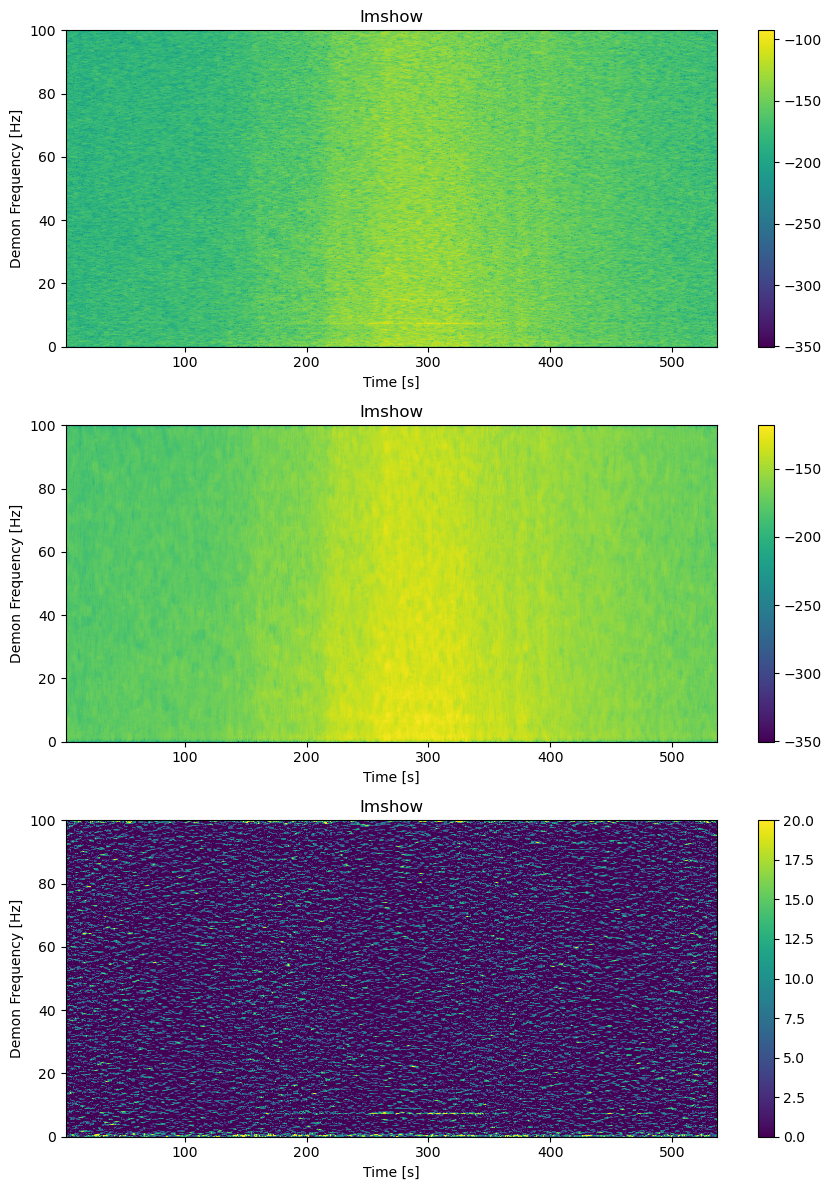

In [ ]:
#Chat gpt / Karl Thomas

import numpy as np
import scipy.signal as signal
from scipy.signal import butter, hilbert, spectrogram, resample_poly
import librosa
import matplotlib.pyplot as plt

# Parameters
pars = {
    "AnalysisWindowwidth": 1,  # Window width in seconds
    "NoiseWindow": [0, 1],  # Background noise estimate in seconds
    "broadband": {
        "FrequencyWindow": [[100, 1000], [500, 5000], [100, 10000]],
        "order": 4,
    },
    "DEMON": {
        "fsd": 200,
        "bandpass": {"f_low": 100, "order": 4},
        "N": 15,
        "NumLines": 5,
        "minfreq": 0,
        "maxfreq": 200,
    },
    "spectrogram": {
        "N": 32 * 1024,
        "N_d": 990,
    },
    "narrowband": {
        "N": 51,
        "minfreq": 50,
        "maxfreq": 1000,
        "NumLines": 5,
    },
}

# DEMON detection

#sd, td, fd = demon_analysis(data, Fs, pars)
#def demon_analysis(audio_data, Fs, pars):

# Load audio file
file_path = "/Users/christofferaaseth/Documents/GitHub/hydrophonic-detection/Sound_data/001029.wav"  # Replace with actual file path
audio_data_org, Fs_org = librosa.load(file_path, sr=None)

#TEST FOR NEDSAMPLING, RESULTAT: GOOD
Fs = 2000
audio_data = resample_poly(audio_data_org,1,int(Fs_org/Fs))


# Design the bandpass filter
b, a = butter(pars['DEMON']['bandpass']['order'], 
                [pars['DEMON']['bandpass']['f_low'] / (Fs / 2), 0.99], 
                btype='bandpass')

# Apply the filter
filtered_audio = signal.filtfilt(b, a, audio_data)

# Define window length
d = round(1 / pars['DEMON']['fsd'] * Fs)
fsd1 = Fs / d

# Calculate number of windows
num_windows = len(filtered_audio) // d

# RMS calculation
rms_values = np.zeros(num_windows)
for i in range(num_windows):
    start_idx = i * d
    end_idx = min((i + 1) * d, len(filtered_audio))
    window_data = filtered_audio[start_idx:end_idx]

    # Envelope detection using Hilbert transform
    rms_values[i] = np.sqrt(np.mean(np.abs(hilbert(window_data))**2 + np.abs(window_data)**2))

# Spectrogram
df1 = 1 / (pars['spectrogram']['N_d'] / fsd1)
print(f"nfft = {int((pars['DEMON']['maxfreq'] - pars['DEMON']['minfreq']) / df1)}")
print(f"nperseg = {pars['spectrogram']['N_d']}")
fd, td, sd = spectrogram(rms_values, fsd1, 
                        nperseg=pars['spectrogram']['N_d'], 
                        noverlap=5 * pars['spectrogram']['N_d'] // 6,
                        nfft=int((pars['DEMON']['maxfreq'] - pars['DEMON']['minfreq']) / df1),
                        scaling='density')

sd_med = signal.medfilt(np.abs(sd) ** 2, kernel_size=[pars["DEMON"]["N"], 1])
DEnorm = np.abs(sd) ** 2 / signal.medfilt(np.abs(sd) ** 2, kernel_size=[pars["DEMON"]["N"], 1])





plt.figure(figsize=(9,12))




plt.subplot(3, 1, 1)
plt.imshow(10 * np.log10(np.abs(sd) ** 2), aspect="auto", origin="lower", extent=[td.min(), td.max(), fd.min(), fd.max()],vmin=None,vmax=None)
plt.colorbar()
plt.xlabel("Time [s]")
plt.ylabel("Demon Frequency [Hz]")
plt.title("Imshow")
plt.subplot(3, 1, 2)
plt.imshow(10 * np.log10(sd_med), aspect="auto", origin="lower", extent=[td.min(), td.max(), fd.min(), fd.max()],vmin=None,vmax=None)
plt.colorbar()
plt.xlabel("Time [s]")
plt.ylabel("Demon Frequency [Hz]")
plt.title("Imshow")
plt.subplot(3, 1, 3)
plt.imshow(10 * np.log10(DEnorm), aspect="auto", origin="lower", extent=[td.min(), td.max(), fd.min(), fd.max()],vmin=0,vmax=20)
plt.colorbar()
plt.xlabel("Time [s]")
plt.ylabel("Demon Frequency [Hz]")
plt.title("Imshow")


plt.tight_layout()

133.33333333333334


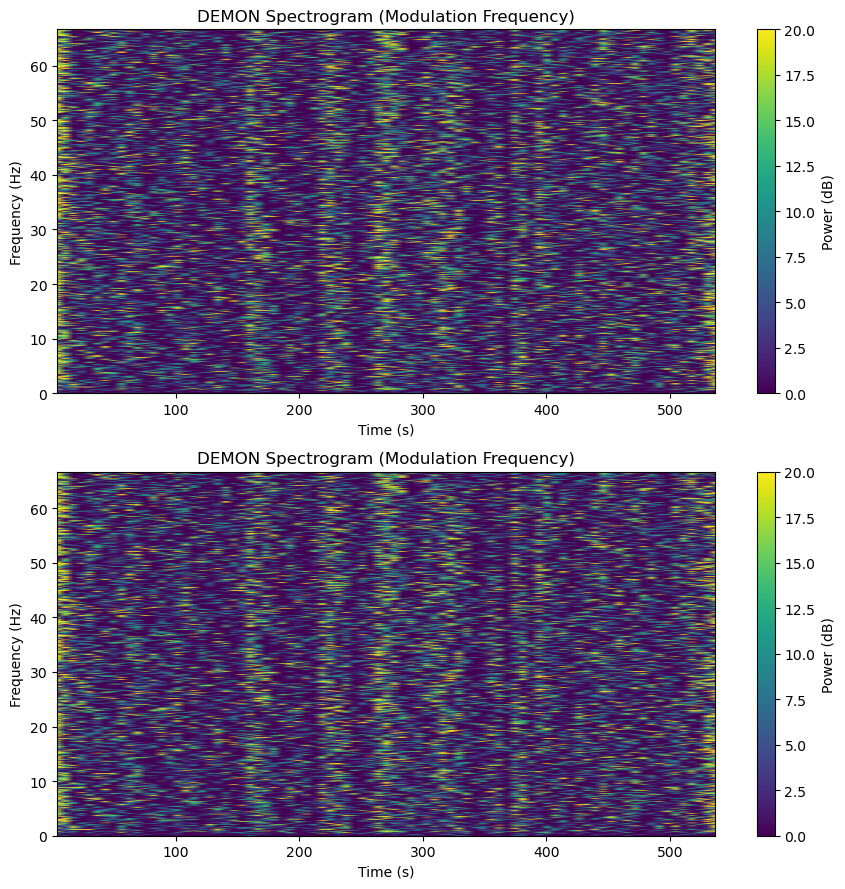

In [89]:
#Min kode

import librosa
import numpy as np
from scipy.signal import hilbert, resample_poly, butter
from scipy import signal
import matplotlib.pyplot as plt

def Hilbert_DS(input_file, Fs:int ,medfilt_window: int, filter_type: int):
    """
    INPUT:
        input_file: audio file to transform
        
        Fs: int
            Frequency to sample the audio file
        medfilt_window: Odd integer
            NEEDS DESCRIPTION
            also used for downsampling in last stage

    OUTPUT:
        DS_Sx: array of float
            Downsampled hilbert transformed data
        DS_Fs: int
            Sample frequency of DS_Fs
        DS_t: array of float
            Time axis corresponding to DS_Sx
    """
    #Getting data from wav file
    data_org, sr = librosa.load(input_file)

    #downsampling original audio data
    data_offcet = resample_poly(data_org,1,int(sr/Fs))

    #Removing Dc-offcet from data
    dc_offcet = np.mean(data_offcet)
    data = data_offcet - dc_offcet
    
    #NEW TEST: FILTRERING AV DATA
    butter_filter_order = 4
    butter_f_low = 100
    b, a = butter(butter_filter_order,[butter_f_low/(Fs/2), 0.99], btype="bandpass")
    filter_data = signal.filtfilt(b,a,data)

    #Hilbert transform ov data
    analytic_signal = np.absolute(hilbert(filter_data))
    #Squaring each element
    h_2 = np.square(analytic_signal)

    #If, only for testing purposes. One of the should be the only one
    if filter_type == 1:
        #median filter
        h_filt = signal.medfilt(h_2,medfilt_window)

        #Downsampling
        DS_Sx = resample_poly(h_filt,1,medfilt_window)
        DS_Fs = Fs/medfilt_window
        DS_t = np.linspace(0,(len(DS_Sx)/DS_Fs),len(DS_Sx))
    elif filter_type == 2:
        #filtered and downsampled alternative
        idx_start = 0
        idx_stop = medfilt_window
        num_windows = len(h_2) // medfilt_window
        #Time lost at end of file due to filter_size
        num_samp  = num_windows*medfilt_window
        lost_samp = len(h_2) - num_samp
        lost_time = lost_samp/Fs
        print(f"Due to filter_size mismatch, {lost_time}[s] is lost at end of file")
        h_filt = np.zeros(num_windows-1)
        try:
            for i in range(num_windows):
                h_filt[i] = np.mean(h_2[idx_start:idx_stop])
                idx_start = idx_stop
                idx_stop += medfilt_window
        except:
            print("Last used idx:",idx_start,",",idx_stop)
            print(f"last possible idx to use: {len(h_2)-1}")
            print(h_filt)
        DS_Sx = h_filt
        DS_Fs = Fs/medfilt_window
        DS_t = np.linspace(0,(len(DS_Sx)/DS_Fs),len(DS_Sx))
    else: print("filter_type must be 1 or 2")

    return DS_Sx, DS_Fs, DS_t

def DEMON_Analasys(Sx, Fs:int, nperseg:int,medfilt_window:int,s_min:int,s_max:int):
    """
    INPUT:
        Sx: Array of float
            Time series of measurement values to make spectrogram of
        Fs: int
            Sample frequency of Sx
        nperseg: int
            Num. of samples in each segment
    """
    #Henter ut spectrogram for DEMON (demon_sx)
    demon_f, demon_t, demon_sx = signal.spectrogram(Sx, Fs, nperseg=nperseg, detrend=False)
    
    #med filt over hver kolonne
    demon_sx_med = np.zeros((len(demon_sx),len(demon_sx[0])))
    for k in range(len(demon_sx)):
        demon_sx_med[k,:] = signal.medfilt(demon_sx[k,:],kernel_size=medfilt_window)

    demon_sx_norm = demon_sx/demon_sx_med
    demon_sx_db = 10*np.log(demon_sx_norm)
    
    plt.figure(figsize=(9,9))
    
    plt.subplot(2,1,1)
    plt.pcolormesh(demon_t, demon_f, demon_sx_db,vmin=s_min,vmax=s_max, shading='gouraud')
    plt.ylabel("Frequency (Hz)")
    plt.xlabel("Time (s)")
    plt.title("DEMON Spectrogram (Modulation Frequency)")
    plt.colorbar(label="Power (dB)")

    plt.subplot(2,1,2)
    plt.imshow(demon_sx_db,aspect="auto", origin="lower", extent=[demon_t.min(),demon_t.max(),demon_f.min(),demon_f.max()])
    plt.pcolormesh(demon_t, demon_f, demon_sx_db,vmin=s_min,vmax=s_max, shading='gouraud')
    plt.ylabel("Frequency (Hz)")
    plt.xlabel("Time (s)")
    plt.title("DEMON Spectrogram (Modulation Frequency)")
    plt.colorbar(label="Power (dB)")

    plt.tight_layout()

    plt.show()
    return 0


input_file = "/Users/christofferaaseth/Documents/GitHub/hydrophonic-detection/Sound_data/001029.wav"

DS_Sx, DS_Fs, DS_t = Hilbert_DS(input_file,Fs=2000,medfilt_window=15,filter_type=1)
print(DS_Fs)

Demon = DEMON_Analasys(DS_Sx, DS_Fs, nperseg=990, medfilt_window=9,s_min=0,s_max=20)

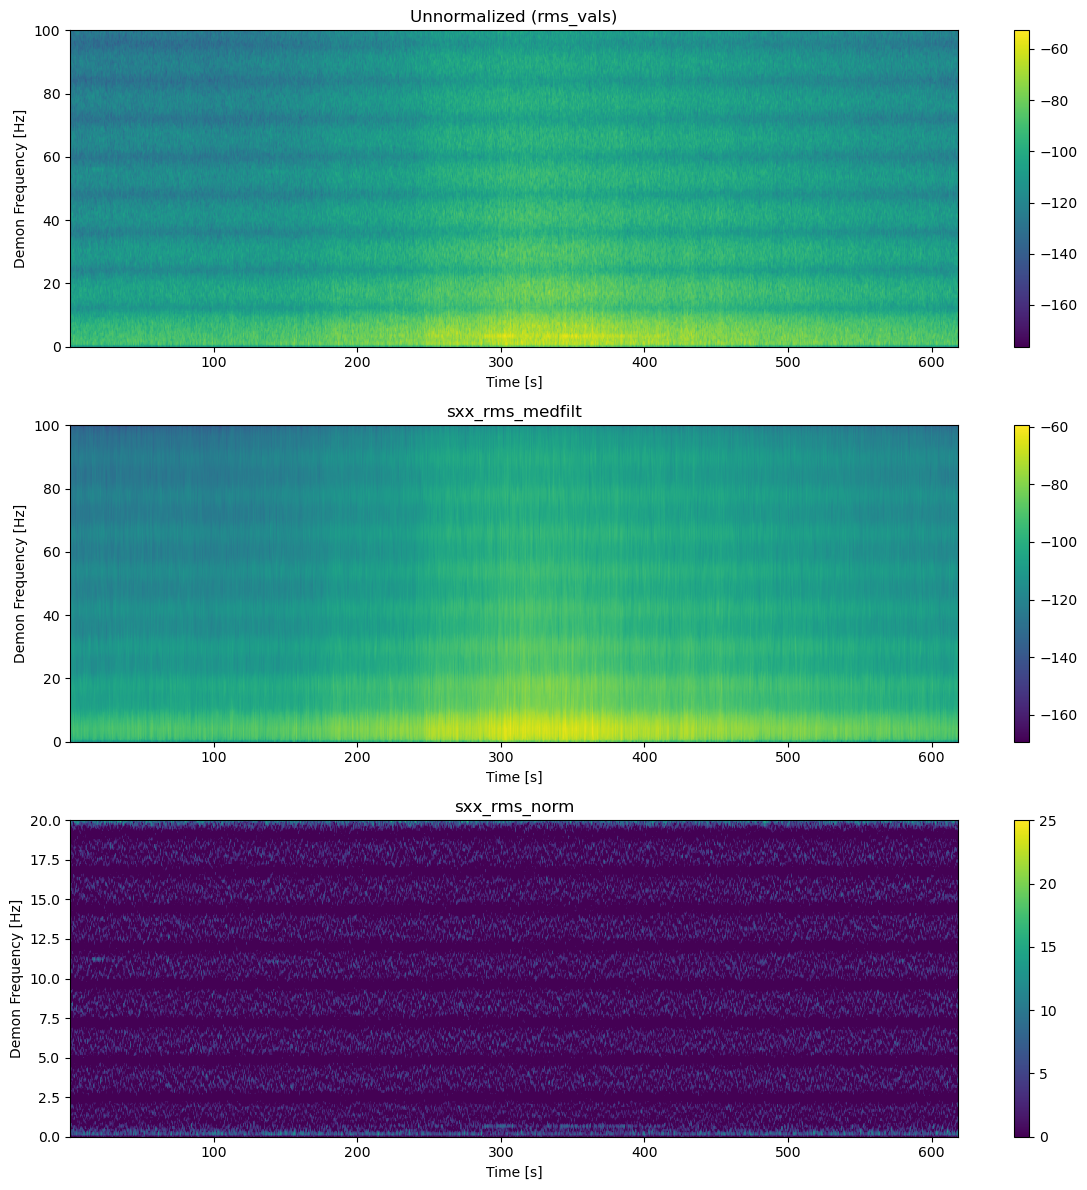

In [1]:
#DEMON 2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample_poly, butter, hilbert
import librosa
import scipy.signal as signal

input_file = "/Users/christofferaaseth/Documents/GitHub/hydrophonic-detection/Sound_data/001029.wav"

#Sampling org data
data_org, sr = librosa.load(input_file)

#Downsample to Fs
Fs = 10000
DS_org = resample_poly(data_org,1,int(sr/Fs))
b,a = signal.butter(N=4,Wn=100, btype="highpass",fs=Fs)
HPF = signal.filtfilt(b,a,DS_org)

#removing dc_offcet
data = HPF - np.mean(HPF)

#RMS data of hilbert
medfilt_window = 400 #Number of samples in time axis of original audio to smooth
kernal_size = medfilt_window + (medfilt_window%2 == 0)
analytic_signal = np.abs(hilbert(data))**2
h_filt = signal.medfilt(analytic_signal,kernal_size)
#Downsampled so that each new sample is a mean of h_filt samples
rms_values  = np.sqrt(resample_poly(h_filt,1,int(Fs/kernal_size)))

#hente freq
nperseg= 400 #Number of samples in time axis to use for each vertical spectrogram coloumn
fd, td, sxx = signal.spectrogram(h_filt,kernal_size,
                                                nperseg=nperseg,
                                                noverlap=5*nperseg//6,
                                                nfft=int(200*kernal_size / nperseg),
                                                )
fd_rms, td_rms, sxx_rms = signal.spectrogram(rms_values,kernal_size,
                                                nperseg=nperseg,
                                                noverlap=5*nperseg//6,
                                                nfft=int(200*kernal_size / nperseg),
                                                )


#med filt over hver kolonne
vertical_medfilt_size  = 15
"""
sxx_med = np.zeros((len(sxx),len(sxx[0])))
for k in range(len(sxx)):
    sxx_med[k] = signal.medfilt(sxx[k],kernel_size=vertical_medfilt_size)

sxx_rms_med = np.zeros((len(sxx_rms),len(sxx_rms[0])))
for k in range(len(sxx_rms)):
    sxx_rms_med[k] = signal.medfilt(sxx_rms[k],kernel_size=vertical_medfilt_size)
"""

sxx_med = np.zeros_like(sxx)
for i in range(sxx.shape[1]):
    sxx_med[:,i] = signal.medfilt(sxx[:,i],kernel_size=vertical_medfilt_size)

sxx_rms_med = np.zeros_like(sxx_rms)
for i in range(sxx_rms.shape[1]):
    sxx_rms_med[:,i] = signal.medfilt(sxx_rms[:,i],kernel_size=vertical_medfilt_size)

#Normaliserer sxx
sxx_norm = sxx/sxx_med
sxx_rms_norm = sxx_rms/sxx_rms_med



#plotting
plt.figure(figsize=(12,12))
"""
plt.subplot(3, 2, 1)
plt.imshow(10 * np.log10(sxx), aspect="auto", origin="lower", extent=[td.min(), td.max(), fd.min(), 20],vmin=None,vmax=None)
plt.colorbar()
plt.xlabel("Time [s]")
plt.ylabel("Demon Frequency [Hz]")
plt.title("Unnormalized (sxx)")

plt.subplot(3, 2, 3)
plt.imshow(10 * np.log10(sxx_med), aspect="auto", origin="lower", extent=[td.min(), td.max(), fd.min(), 20],vmin=None,vmax=None)
plt.colorbar()
plt.xlabel("Time [s]")
plt.ylabel("Demon Frequency [Hz]")
plt.title("sxx_medfilt")

plt.subplot(3, 2, 5)
plt.imshow(10 * np.log10(sxx_norm), aspect="auto", origin="lower", extent=[td.min(), td.max(), fd.min(), 20],vmin=0,vmax=25)
plt.colorbar()
plt.xlabel("Time [s]")
plt.ylabel("Demon Frequency [Hz]")
plt.title("sxx_norm")
"""


#rms test plot
plt.subplot(3, 1, 1)
plt.imshow(10 * np.log10(sxx_rms), aspect="auto", origin="lower", extent=[td_rms.min(), td_rms.max(), fd_rms.min(), 100],vmin=None,vmax=None)
plt.colorbar()
plt.xlabel("Time [s]")
plt.ylabel("Demon Frequency [Hz]")
plt.title("Unnormalized (rms_vals)")

plt.subplot(3, 1, 2)
plt.imshow(10 * np.log10(sxx_rms_med), aspect="auto", origin="lower", extent=[td_rms.min(), td_rms.max(), fd_rms.min(), 100],vmin=None,vmax=None)
plt.colorbar()
plt.xlabel("Time [s]")
plt.ylabel("Demon Frequency [Hz]")
plt.title("sxx_rms_medfilt")

plt.subplot(3,1, 3)
plt.imshow(10 * np.log10(sxx_rms_norm), aspect="auto", origin="lower", extent=[td_rms.min(), td_rms.max(), fd_rms.min(), 20],vmin=0,vmax=25)
plt.colorbar()
plt.xlabel("Time [s]")
plt.ylabel("Demon Frequency [Hz]")
plt.title("sxx_rms_norm")


plt.tight_layout()

In [ ]:

#DEMON 2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample_poly, butter, hilbert
import librosa
import scipy.signal as signal

input_file = "/Users/christofferaaseth/Documents/GitHub/hydrophonic-detection/Sound_data/Wav_files/41.wav"

#Sampling org data
data_org, sr = librosa.load(input_file)

#Downsample to Fs
Fs = 10000
DS_org = resample_poly(data_org,1,int(sr/Fs))
b,a = signal.butter(N=4,Wn=100, btype="highpass",fs=Fs)
HPF = signal.filtfilt(b,a,DS_org)

#removing dc_offcet
data = HPF - np.mean(HPF)

#RMS data of hilbert
medfilt_window = 1400 #Number of samples in time axis of original audio to smooth
kernal_size = medfilt_window + (medfilt_window%2 == 0)
analytic_signal = np.abs(hilbert(data))**2
h_filt = signal.medfilt(analytic_signal,kernal_size)
#Downsampled so that each new sample is a mean of h_filt samples
rms_values  = np.sqrt(resample_poly(h_filt,1,int(Fs/kernal_size)))

#hente freq
nperseg= kernal_size*3 #Number of samples in time axis to use for each vertical spectrogram coloumn

fd_rms, td_rms, sxx_rms = signal.spectrogram(rms_values,kernal_size,
                                                nperseg=nperseg,
                                                noverlap=5*nperseg//6,
                                                #nfft=int(200*kernal_size / nperseg),
                                                window="hamming"
                                                )


#med filt over hver kolonne
vertical_medfilt_size  = 15
sxx_rms_med = np.zeros_like(sxx_rms)
for i in range(sxx_rms.shape[1]):
    sxx_rms_med[:,i] = signal.medfilt(sxx_rms[:,i],kernel_size=vertical_medfilt_size)

#Normaliserer sxx

sxx_rms_norm = sxx_rms/sxx_rms_med



#plotting
plt.figure(figsize=(12,12))

#rms test plot
plt.subplot(3, 1, 1)
plt.imshow(10 * np.log10(sxx_rms), aspect="auto", origin="lower", extent=[td_rms.min(), td_rms.max(), fd_rms.min(), fd_rms.max()],vmin=None,vmax=None)
plt.colorbar()
plt.xlabel("Time [s]")
plt.ylabel("Demon Frequency [Hz]")
plt.title("Unnormalized (rms_vals)")

plt.subplot(3, 1, 2)
plt.imshow(10 * np.log10(sxx_rms_med), aspect="auto", origin="lower", extent=[td_rms.min(), td_rms.max(), fd_rms.min(), fd_rms.max()],vmin=None,vmax=None)
plt.colorbar()
plt.xlabel("Time [s]")
plt.ylabel("Demon Frequency [Hz]")
plt.title("sxx_rms_medfilt")
"""
plt.subplot(3,1, 3)
plt.imshow(10 * np.log10(sxx_rms_norm), aspect="auto", origin="lower", extent=[td_rms.min(), td_rms.max(), fd_rms.min(), fd_rms.max()],vmin=0,vmax=25)
plt.colorbar()
plt.xlabel("Time [s]")
plt.ylabel("Demon Frequency [Hz]")
plt.title("sxx_rms_norm")
"""
plt.subplot(3,1, 3)
#plt.imshow(10 * np.log10(sxx_rms_norm), aspect="auto", origin="lower", extent=[td_rms.min(), td_rms.max(), fd_rms.min(), fd_rms.max()],vmin=0,vmax=25)
plt.pcolormesh(td_rms, fd_rms, 10*np.log10(sxx_rms_norm) > 10, vmin=0,vmax=1)
plt.xlabel("Time [s]")
plt.ylabel("Demon Frequency [Hz]")
plt.ylim(0,700)
plt.title("sxx_rms_norm")
plt.colorbar(label="Magnitude [dB]")  # Colorbar for intensity scale


plt.tight_layout()